In [1]:
import warnings
import numba


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=numba.NumbaDeprecationWarning)


import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import utils
import umap
from functools import partial
from tqdm import trange

# Hyperparameters

In [2]:
n_epochs_1d = 10000
n_neighbors_frac = 0.5
max_dim = 6
n_reference = 40
n_nearest_frac = 0.25
threshold = 0.01

In [3]:
def apply_algorithm(name, plot_trajectories, show_embedding, get_params=lambda x: x):
    # read the data
    data_npz = np.load(f"data/{name}.npz")
    raw_data = data_npz["data"] # raw_data is a np.ndarray of shape (n_trajectories, trajectory_length, state_length)
    params = data_npz["params"] # conserved quantities computed theoretically
    data = StandardScaler().fit_transform(np.concatenate(list(raw_data))).reshape(raw_data.shape)

    # show the data
    print("raw data")
    plot_trajectories(raw_data)
    print("normalized data")
    plot_trajectories(data)

    # compute Wasserstein distances
    print("Computing Wasserstein distances...")
    dmat = utils.gen_dist_matrix(data)

    # show Wasserstein distance matrix
    plt.matshow(dmat)
    plt.title("Wasserstein distance matrix")
    plt.gca().xaxis.set_label_position('top')
    plt.xlabel("index #1")
    plt.ylabel("index #2")
    plt.colorbar()
    plt.show()

    # compute UMAP embeddings
    print("Computing embeddings...")
    embeddings = []

    UMAP = partial(umap.UMAP, n_neighbors=int(n_neighbors_frac * len(dmat)), metric="precomputed")

    periodic_embedding = UMAP(n_components=1,
                            output_metric=utils.circle_metric,
                            n_epochs=n_epochs_1d).fit_transform(dmat)
    periodic_embedding = np.vectorize(utils.normalize_angle)(periodic_embedding)
    embeddings.append(periodic_embedding)

    for n_components in trange(1, max_dim + 1):
        if n_components == 1:
            embedding = UMAP(n_components=n_components, n_epochs=n_epochs_1d).fit_transform(dmat)
        else:
            embedding = UMAP(n_components=n_components).fit_transform(dmat)
        embeddings.append(embedding)

    # compute scores
    order_score = utils.OrderScore(dmat, n_reference, int(n_nearest_frac * len(dmat)))

    scores = []
    errors = []

    score, error = order_score.order_score(embeddings[0], output_metric=utils.circle_metric_without_grad)
    scores.append(score)
    errors.append(error)

    for embedding in embeddings[1:]:
        score, error = order_score.order_score(embedding)
        scores.append(score)
        errors.append(error)

    # show scores and score differences
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    predicted_n_conserved = utils.get_stop_point(scores, threshold)
    print(f"predicted number of conservation laws: {predicted_n_conserved}")

    utils.plot_scores(ax1, scores, errors)
    utils.plot_score_diffs(ax2, scores, errors, predicted_n_conserved, threshold)
    plt.show()

    # show embeddings
    show_embedding(embeddings, get_params(params))


def show_embedding_1d(embeddings, params, quantity_name="energy"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    utils.plot_1d(fig, ax1, embeddings[1], *params.T, quantity_name)
    utils.plot_embedding_vs_conserved_quantity(ax2, embeddings[1], *params.T, quantity_name)


def show_embedding_1d_periodic(embeddings, params, quantity_name="spatial phase"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    utils.plot_periodic_1d(fig, ax1, embeddings[0], *params.T, quantity_name)
    utils.plot_embedding_vs_conserved_quantity(ax2, embeddings[1], *params.T, quantity_name)


def show_embedding_2d(embeddings, params, quantity_names=["energy1", "energy2"]):
    utils.plot_all_2d(*plt.subplots(1, 2, figsize=(15, 5)), embeddings[2], params, quantity_names)


def show_embedding_3d(embeddings, params, quantity_names=["energy", "angular momentum", "orientation angle"]):
    utils.plot_all_3d(*plt.subplots(3, 3, figsize=(15, 15)), embeddings[3], params, quantity_names)


plt.rcParams.update({'font.size': 10})


# Harmonic oscillator

raw data


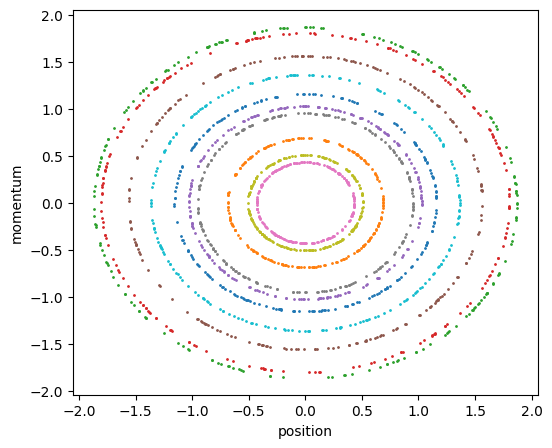

normalized data


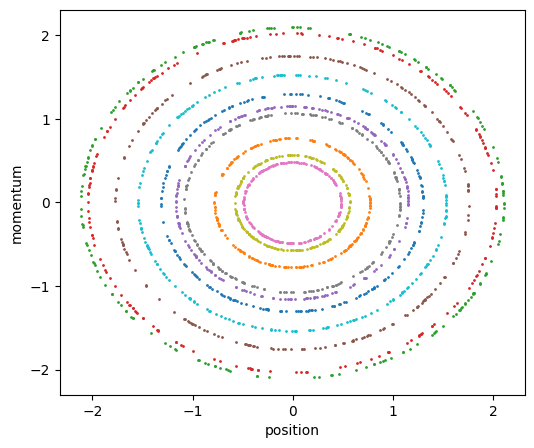

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0010s
   1990 / 19900  EMDs computed  -  10.00% completed - 5.800s
   3980 / 19900  EMDs computed  -  20.00% completed - 13.020s
   5970 / 19900  EMDs computed  -  30.00% completed - 18.050s
   7960 / 19900  EMDs computed  -  40.00% completed - 23.092s
   9950 / 19900  EMDs computed  -  50.00% completed - 27.694s
  11940 / 19900  EMDs computed  -  60.00% completed - 32.474s
  13930 / 19900  EMDs computed  -  70.00% completed - 37.265s
  15920 / 19900  EMDs computed  -  80.00% completed - 42.250s
  17910 / 19900  EMDs computed  -  90.00% completed - 47.567s
  19900 / 19900  EMDs computed  - 100.00% completed - 52.965s


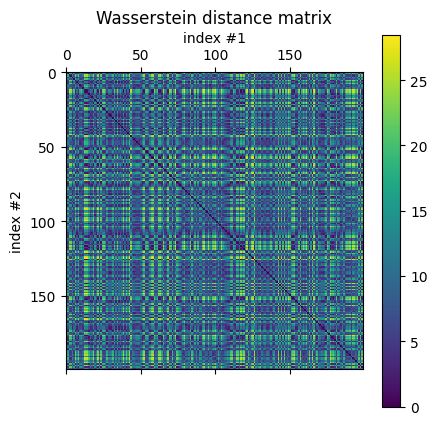

Computing embeddings...


100%|██████████| 6/6 [00:31<00:00,  5.31s/it]


predicted number of conservation laws: 2


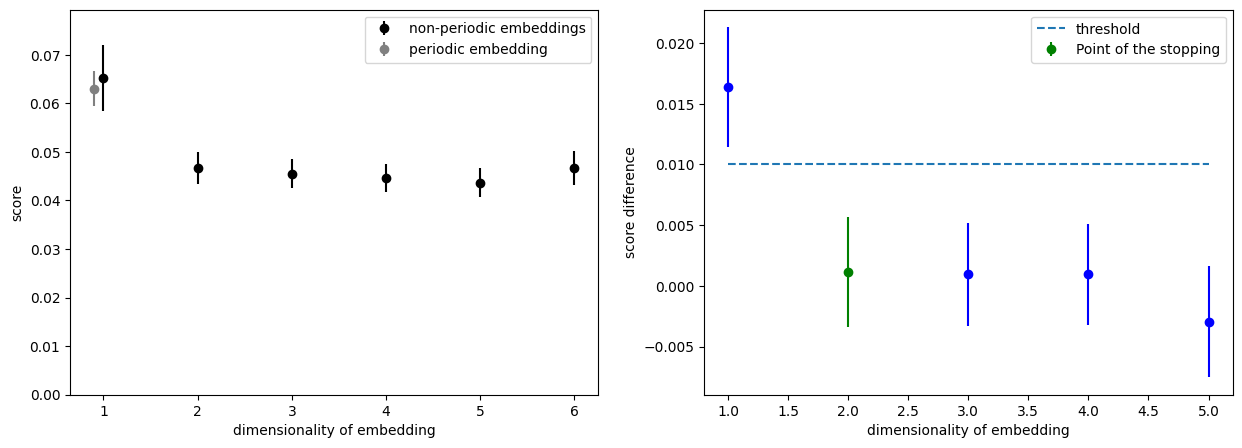

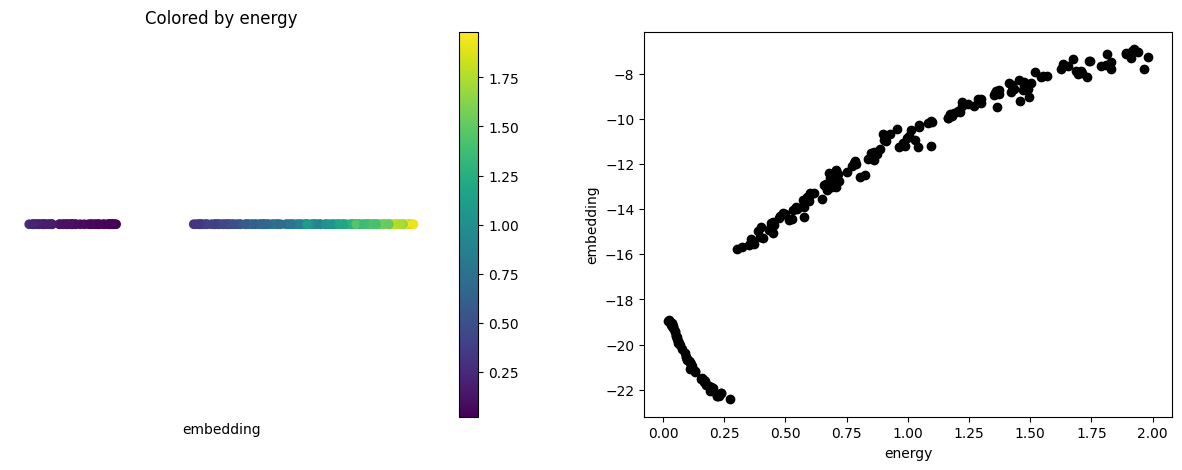

In [4]:
def plot_trajectories_ho(data, N_traj=10):
    plt.figure(figsize=(6, 5))
    for traj in data[:N_traj]:
        plt.scatter(*traj.T, s=1)
    plt.xlabel("position")
    plt.ylabel("momentum")
    plt.show()


apply_algorithm("harmonic_oscillator", plot_trajectories_ho, show_embedding_1d)

# Double pendulum

In [5]:
def plot_trajectories_dp(data, N_traj=3):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, ax in enumerate(axes):
        for traj in data[range(N_traj)]:
            ax.scatter(*traj[:, [2 * i, 2 * i + 1]].T)
        ax.set_xlabel("$\\theta_" + str(i + 1) + "$")
        ax.set_ylabel("$\\frac{\\mathrm{d}\\theta_" + str(i + 1) + "}{\\mathrm{d}t}$")

    plt.show()

## Low energy

raw data


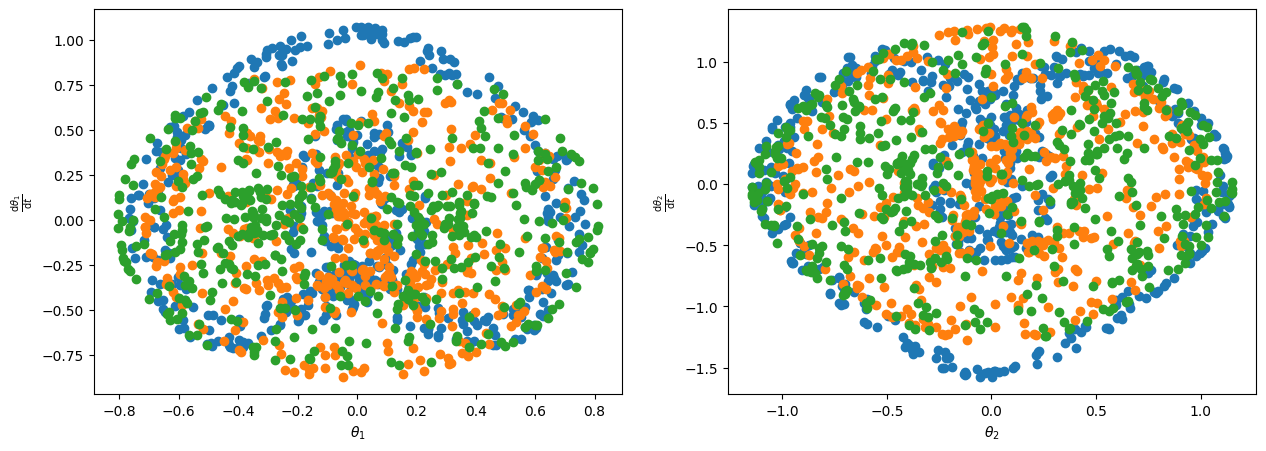

normalized data


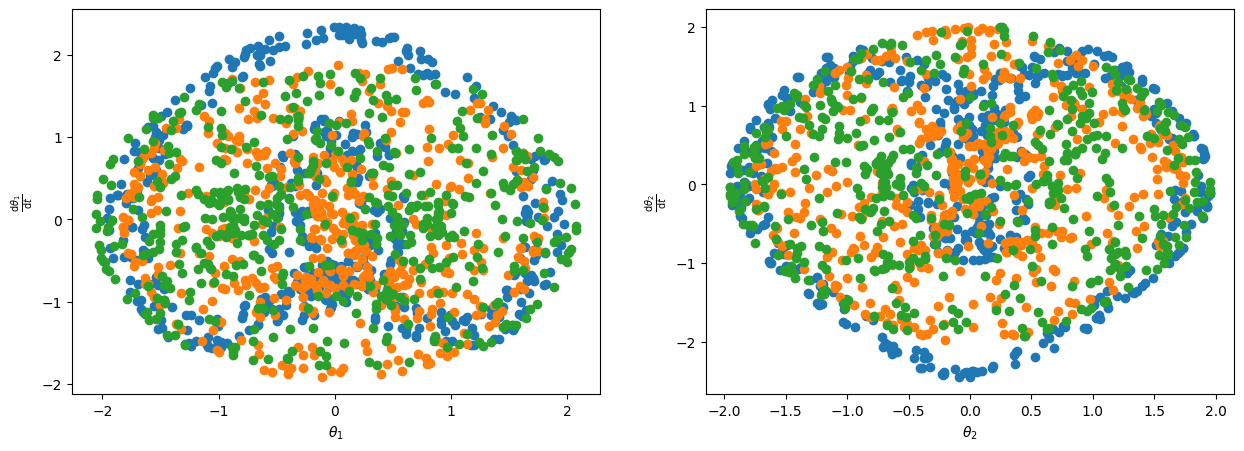

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0036s
   1990 / 19900  EMDs computed  -  10.00% completed - 20.775s
   3980 / 19900  EMDs computed  -  20.00% completed - 43.081s
   5970 / 19900  EMDs computed  -  30.00% completed - 62.675s
   7960 / 19900  EMDs computed  -  40.00% completed - 81.688s
   9950 / 19900  EMDs computed  -  50.00% completed - 104.977s
  11940 / 19900  EMDs computed  -  60.00% completed - 127.009s
  13930 / 19900  EMDs computed  -  70.00% completed - 149.887s
  15920 / 19900  EMDs computed  -  80.00% completed - 170.454s
  17910 / 19900  EMDs computed  -  90.00% completed - 190.985s
  19900 / 19900  EMDs computed  - 100.00% completed - 218.605s


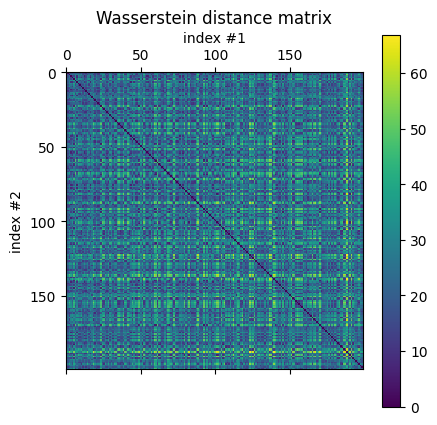

Computing embeddings...


100%|██████████| 6/6 [00:21<00:00,  3.65s/it]


predicted number of conservation laws: 2


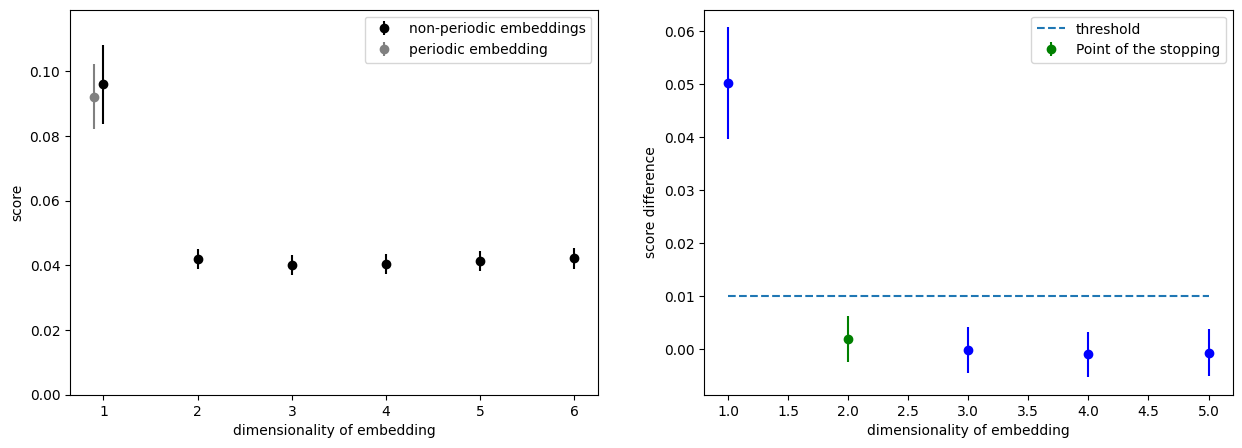

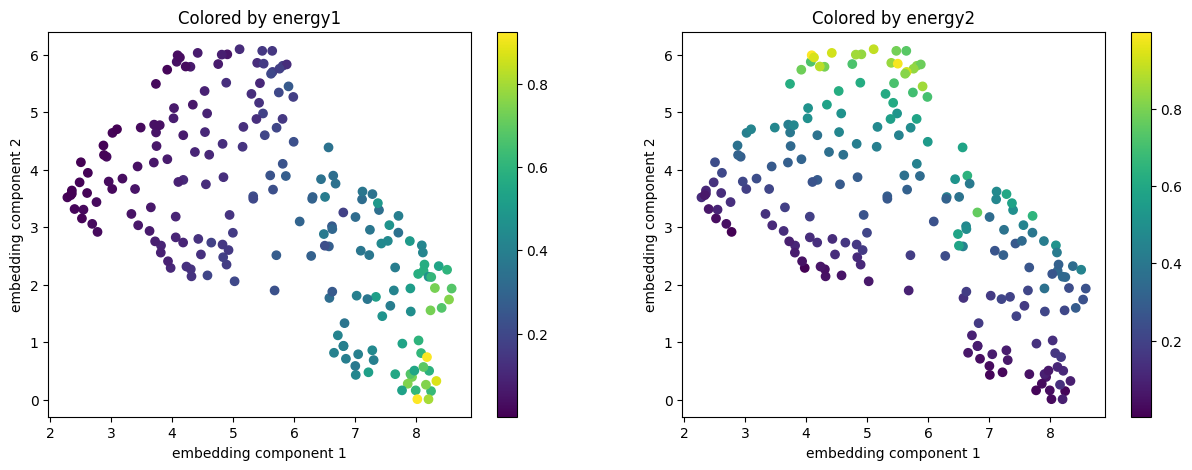

In [6]:
apply_algorithm("double_pendulum_low_energy", plot_trajectories_dp, show_embedding_2d,lambda params: params[:, [1, 2]])

## High energy

raw data


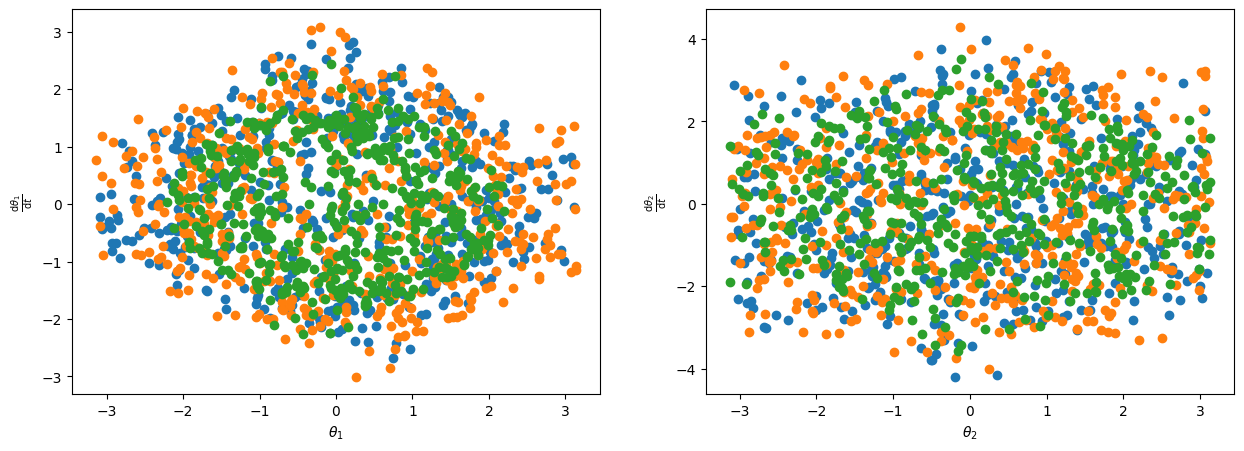

normalized data


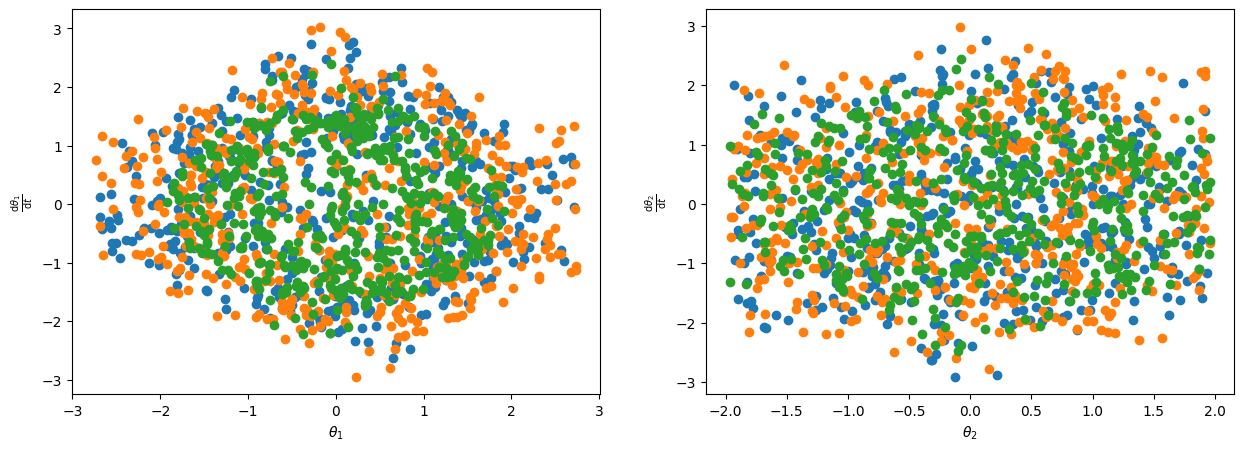

Computing Wasserstein distances...
Finished preprocessing 400 events in 0.0050s
   7980 / 79800  EMDs computed  -  10.00% completed - 76.278s
  15960 / 79800  EMDs computed  -  20.00% completed - 154.624s
  23940 / 79800  EMDs computed  -  30.00% completed - 233.693s
  31920 / 79800  EMDs computed  -  40.00% completed - 312.876s
  39900 / 79800  EMDs computed  -  50.00% completed - 390.711s
  47880 / 79800  EMDs computed  -  60.00% completed - 469.685s
  55860 / 79800  EMDs computed  -  70.00% completed - 549.140s
  63840 / 79800  EMDs computed  -  80.00% completed - 629.353s
  71820 / 79800  EMDs computed  -  90.00% completed - 708.342s
  79800 / 79800  EMDs computed  - 100.00% completed - 787.156s


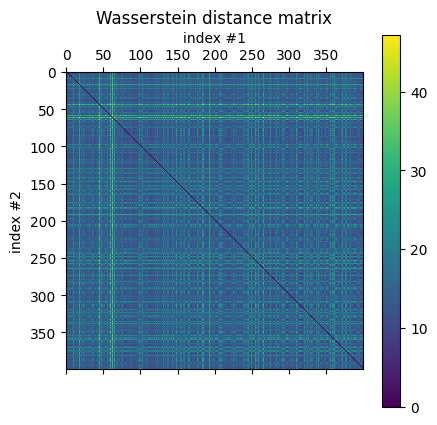

Computing embeddings...


100%|██████████| 6/6 [00:31<00:00,  5.29s/it]


predicted number of conservation laws: 1


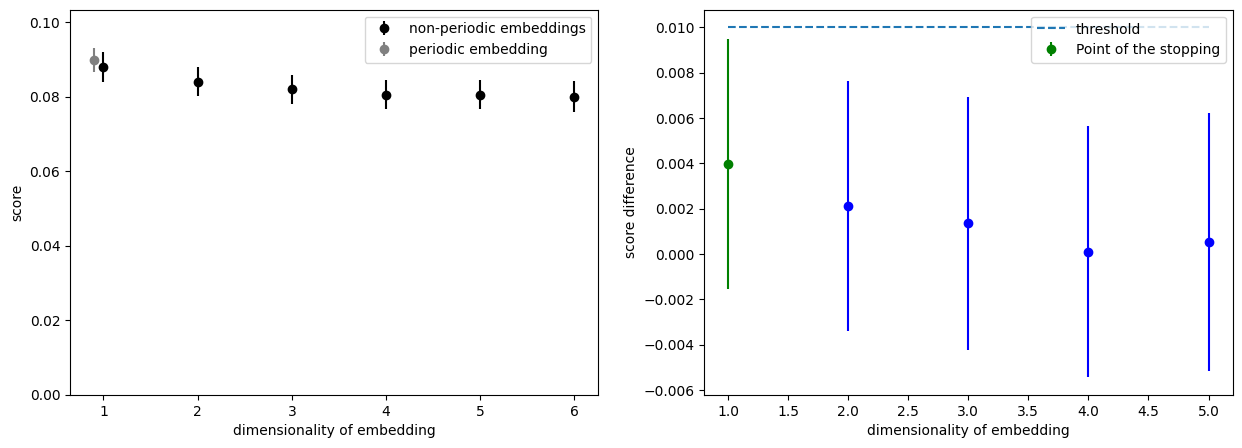

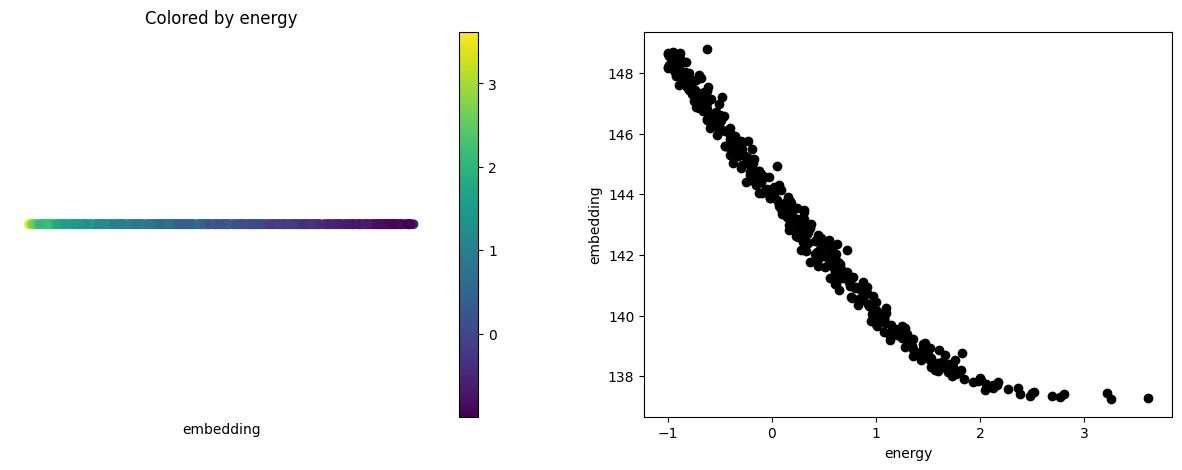

In [7]:
apply_algorithm("double_pendulum_high_energy", plot_trajectories_dp, show_embedding_1d, lambda params: params[:, :1])

# Kepler problem

In [8]:
def plot_trajectories_kp(data, N_traj=10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for traj in data[:N_traj]:
        ax1.scatter(*traj.T[:2], s=1)
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")

    for traj in data[:N_traj]:
        ax2.scatter(*traj.T[2:], s=1)
    ax2.set_xlabel("$\\frac{\\mathrm{d}x_1}{\\mathrm{d}t}$")
    ax2.set_ylabel("$\\frac{\\mathrm{d}x_2}{\\mathrm{d}t}$")

    plt.show()

raw data


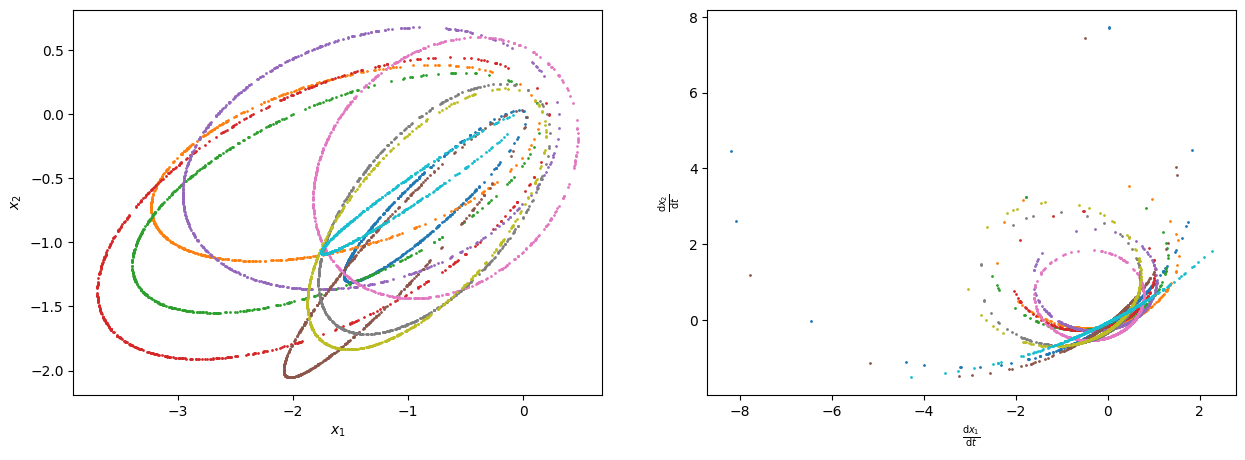

normalized data


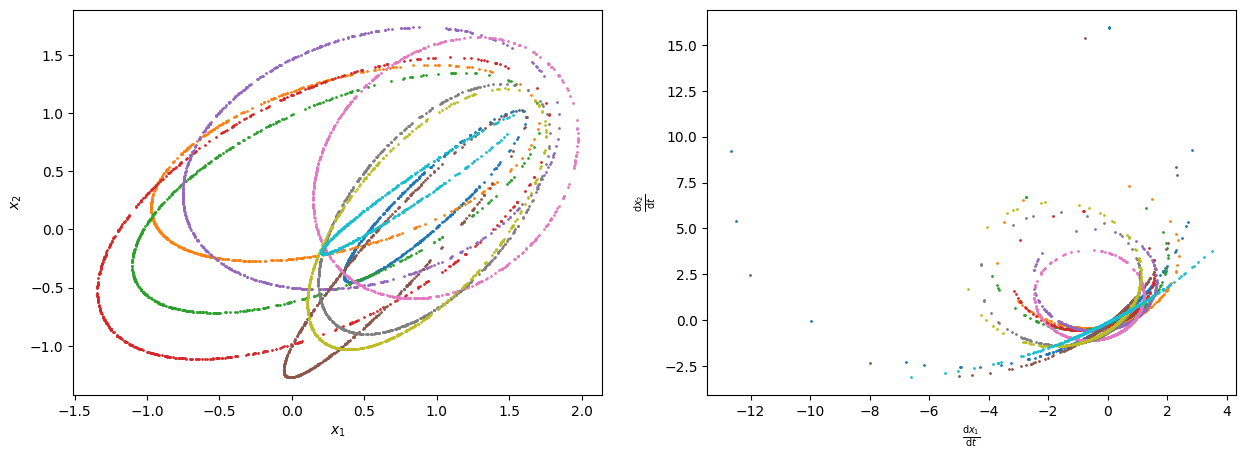

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0020s


PairwiseEMD::compute - Issue with EMD between events (197, 42), error code 4


   1990 / 19900  EMDs computed  -  10.00% completed - 37.277s


PairwiseEMD::compute - Issue with EMD between events (13, 9), error code 4
PairwiseEMD::compute - Issue with EMD between events (180, 107), error code 4


   3980 / 19900  EMDs computed  -  20.00% completed - 80.499s


PairwiseEMD::compute - Issue with EMD between events (175, 54), error code 4
PairwiseEMD::compute - Issue with EMD between events (170, 58), error code 4
PairwiseEMD::compute - Issue with EMD between events (175, 102), error code 4
PairwiseEMD::compute - Issue with EMD between events (172, 95), error code 4


   5970 / 19900  EMDs computed  -  30.00% completed - 126.347s


PairwiseEMD::compute - Issue with EMD between events (169, 112), error code 4
PairwiseEMD::compute - Issue with EMD between events (160, 150), error code 4


   7960 / 19900  EMDs computed  -  40.00% completed - 165.769s


PairwiseEMD::compute - Issue with EMD between events (152, 54), error code 4
PairwiseEMD::compute - Issue with EMD between events (154, 28), error code 4


   9950 / 19900  EMDs computed  -  50.00% completed - 203.583s


PairwiseEMD::compute - Issue with EMD between events (56, 54), error code 4
PairwiseEMD::compute - Issue with EMD between events (141, 79), error code 4


  11940 / 19900  EMDs computed  -  60.00% completed - 246.287s


PairwiseEMD::compute - Issue with EMD between events (139, 86), error code 4
PairwiseEMD::compute - Issue with EMD between events (65, 9), error code 4
PairwiseEMD::compute - Issue with EMD between events (137, 84), error code 4


  13930 / 19900  EMDs computed  -  70.00% completed - 288.880s


PairwiseEMD::compute - Issue with EMD between events (123, 46), error code 4
PairwiseEMD::compute - Issue with EMD between events (124, 46), error code 4


  15920 / 19900  EMDs computed  -  80.00% completed - 318.282s


PairwiseEMD::compute - Issue with EMD between events (88, 60), error code 4
PairwiseEMD::compute - Issue with EMD between events (114, 20), error code 4


  17910 / 19900  EMDs computed  -  90.00% completed - 353.228s


PairwiseEMD::compute - Issue with EMD between events (99, 60), error code 4


  19900 / 19900  EMDs computed  - 100.00% completed - 388.843s


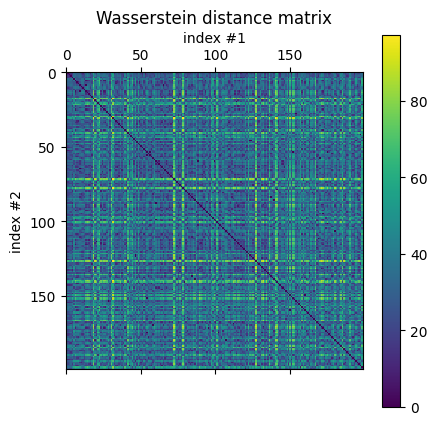

Computing embeddings...


100%|██████████| 6/6 [00:22<00:00,  3.72s/it]


predicted number of conservation laws: 3


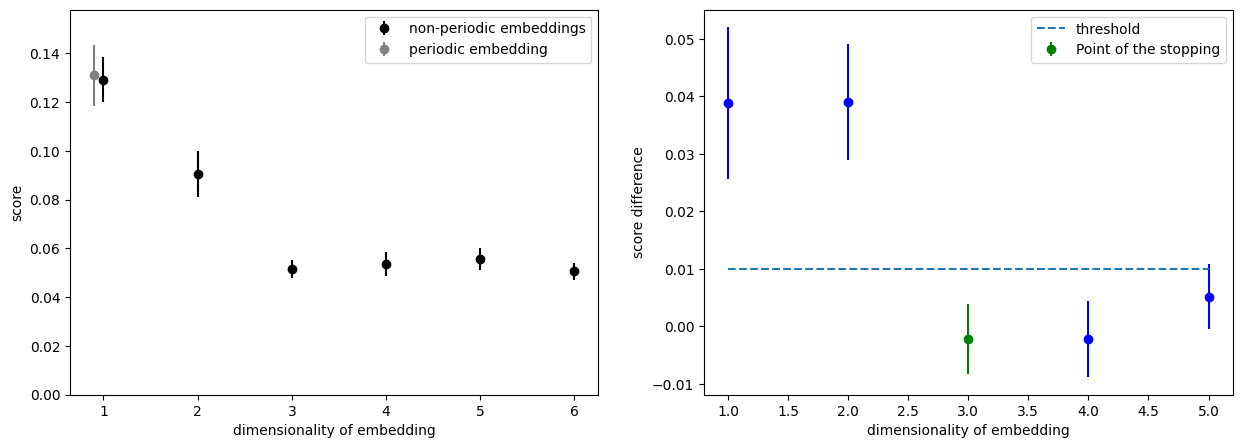

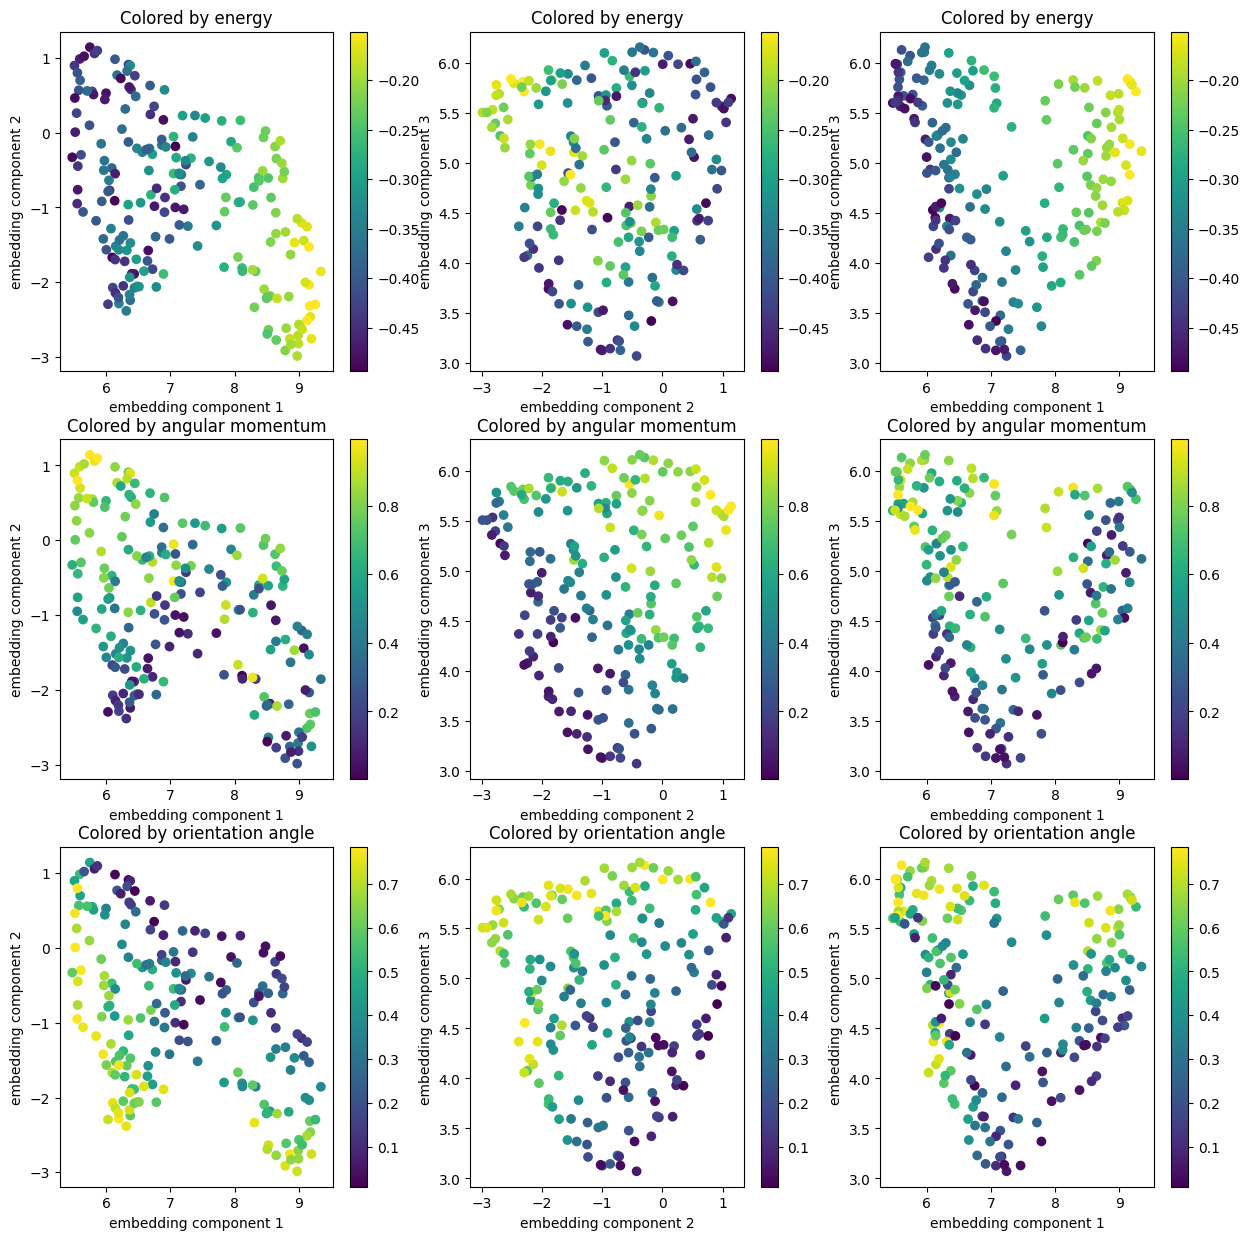

In [9]:
apply_algorithm("kepler_problem", plot_trajectories_kp, show_embedding_3d)

# Oscillating Turing patterns

In [10]:
def plot_trajectories_turing(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, ax in enumerate(axes):
        image = ax.imshow(data[0,:,i::2].T, aspect='auto', origin='lower')
        ax.set_xlabel('Sample Number')
        ax.set_ylabel('$x$')
        ax.set_yticks([0,12.5, 25, 37.5],[0, 2, 4, 6])
        fig.colorbar(image, ax=ax)
        f = "v" if i else "u"
        ax.set_title("$" + "f" + "(x)$")

    plt.show()


raw data


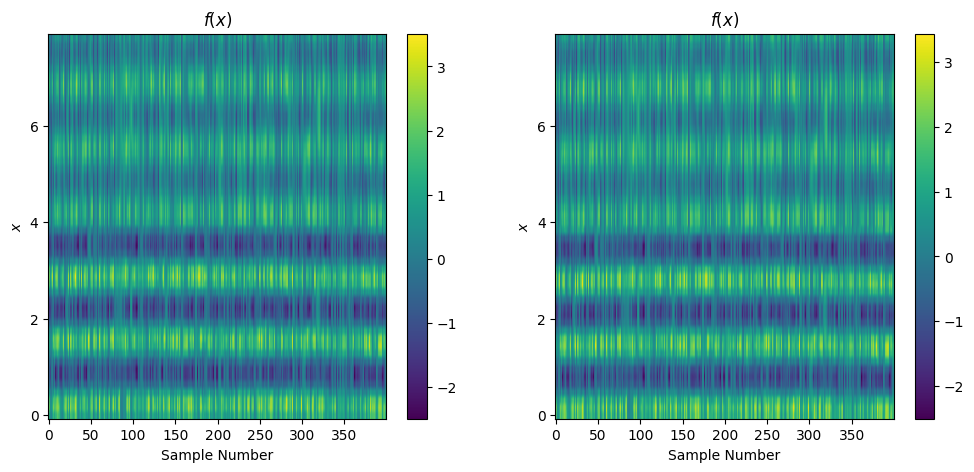

normalized data


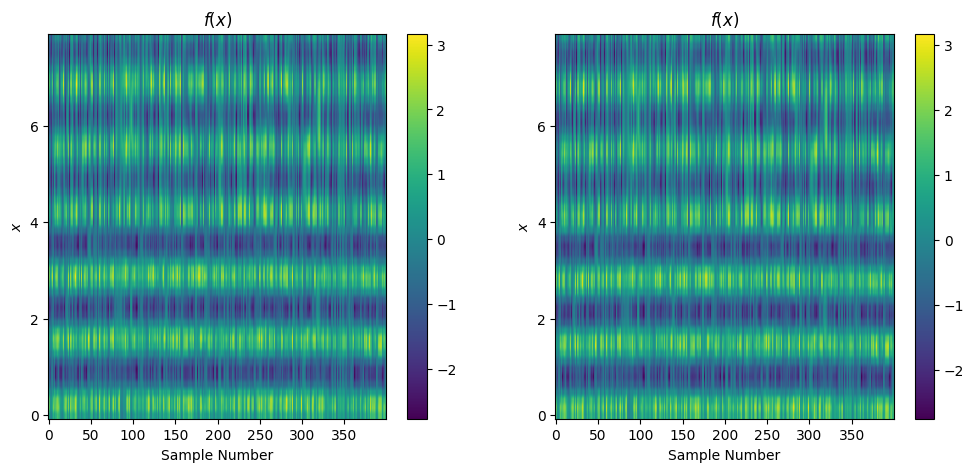

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0604s
   1990 / 19900  EMDs computed  -  10.00% completed - 19.526s
   3980 / 19900  EMDs computed  -  20.00% completed - 40.110s
   5970 / 19900  EMDs computed  -  30.00% completed - 60.916s
   7960 / 19900  EMDs computed  -  40.00% completed - 81.484s
   9950 / 19900  EMDs computed  -  50.00% completed - 102.239s
  11940 / 19900  EMDs computed  -  60.00% completed - 123.100s
  13930 / 19900  EMDs computed  -  70.00% completed - 143.890s
  15920 / 19900  EMDs computed  -  80.00% completed - 164.627s
  17910 / 19900  EMDs computed  -  90.00% completed - 185.571s
  19900 / 19900  EMDs computed  - 100.00% completed - 206.340s


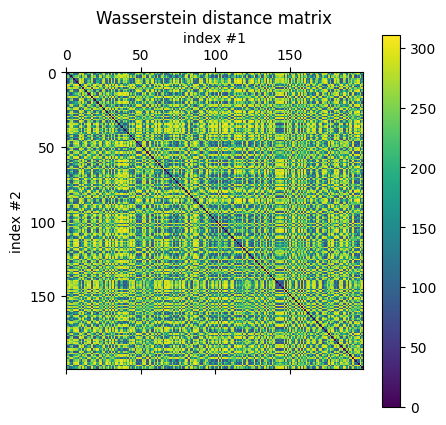

Computing embeddings...


100%|██████████| 6/6 [00:20<00:00,  3.44s/it]


predicted number of conservation laws: 1


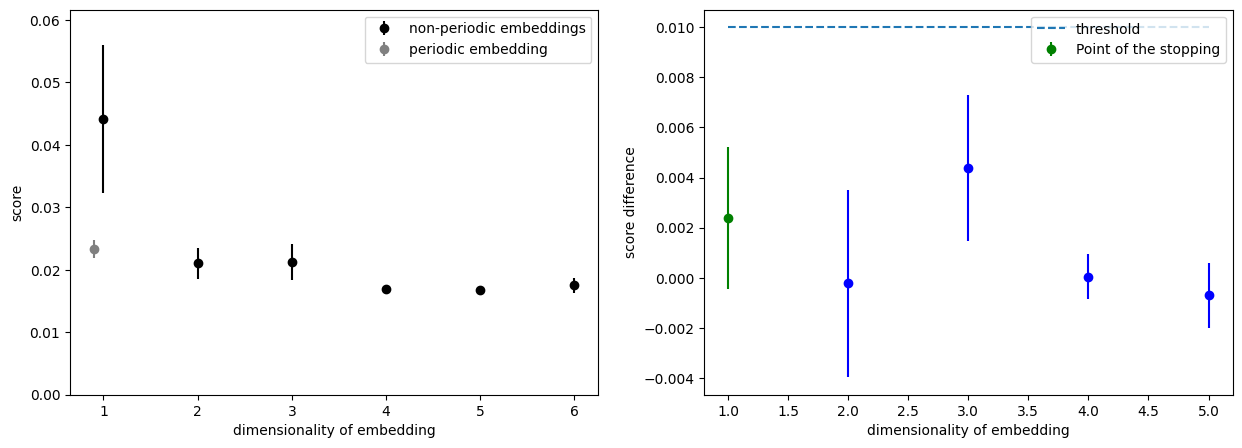

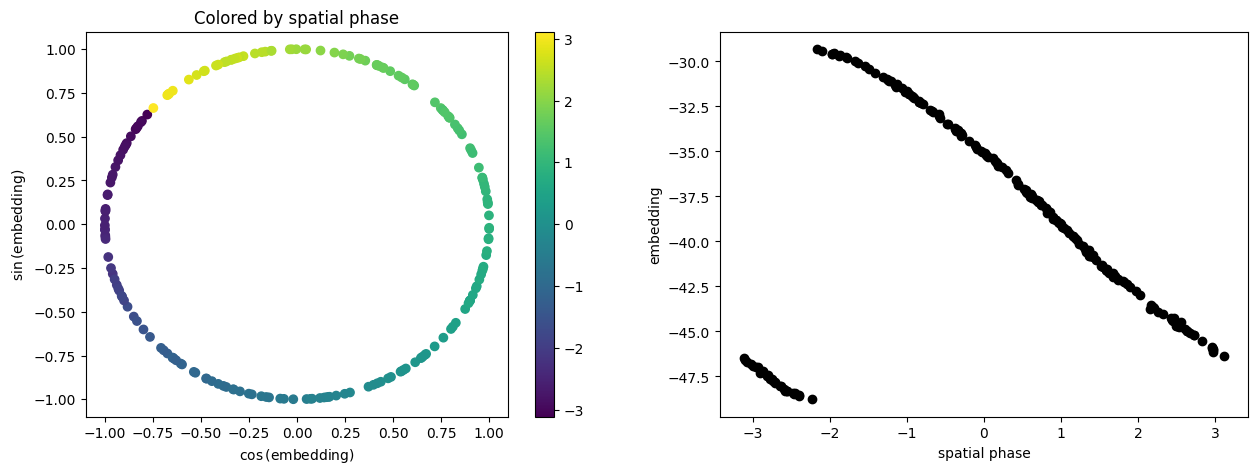

In [11]:
apply_algorithm("turing", plot_trajectories_turing, show_embedding_1d_periodic)